# SS6-1 Killernay vs LLM Extraction — Cross-Check Analysis

Compares vote counts extracted by **Gemini 2.5 Pro (thinking=LOW)** against the **killernay** ground-truth dataset for Thailand's 2026 general election.

| File | Description |
|------|-------------|
| `assets/killernay/constituency.csv` | Killernay ground truth — แบ่งเขต |
| `assets/killernay/party_list.csv` | Killernay ground truth — บัญชีรายชื่อ |
| `assets/killernay/llm_constituency.csv` | LLM extraction result — แบ่งเขต (killernay format) |
| `assets/killernay/llm_party_list.csv` | LLM extraction result — บัญชีรายชื่อ (killernay format) |

Both source and LLM files share the **same CSV schema**, making comparison straightforward.

## 1. Setup & Imports

In [4]:
!pip install matplotlib seaborn -q

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from IPython.display import display
from pathlib import Path

matplotlib.rcParams['font.family'] = ['Tahoma', 'DejaVu Sans']
pd.set_option('display.max_colwidth', 60)
pd.set_option('display.max_rows', 100)

ASSETS = Path('assets/killernay')
print('ASSETS:', ASSETS.resolve())

ASSETS: /Users/nuttee.jirattivongvibul/Projects/genai-app-python/notebooks/assets/killernay


## 2. Load Data

Both killernay and LLM results share the same column schema:
- **Constituency**: `province_code, province, constituency, number, candidate_name, party, votes`
- **Party-list**: `province_code, province, constituency, number, party, votes`

In [32]:
CON_COLS = ['province_code', 'province', 'constituency', 'number', 'candidate_name', 'party', 'votes']
PL_COLS  = ['province_code', 'province', 'constituency', 'number', 'party', 'votes']

def load_csv(path, cols):
    df = pd.read_csv(path, header=0)
    df.columns = cols
    df['constituency'] = df['constituency'].astype(int)
    df['number']       = pd.to_numeric(df['number'], errors='coerce').astype('Int64')
    df['votes']        = pd.to_numeric(df['votes'],  errors='coerce').fillna(0).astype(int)
    return df

# Killernay ground truth
kn_con = load_csv(ASSETS / 'constituency.csv', CON_COLS)
kn_pl  = load_csv(ASSETS / 'party_list.csv',   PL_COLS)

# LLM extraction results
llm_con = load_csv(ASSETS / 'llm_constituency.csv', CON_COLS)
llm_pl  = load_csv(ASSETS / 'llm_party_list.csv',   PL_COLS)

print(f'Killernay  constituency: {len(kn_con):>6,} rows  |  LLM constituency: {len(llm_con):>6,} rows')
print(f'Killernay  party-list:   {len(kn_pl):>6,} rows  |  LLM party-list:   {len(llm_pl):>6,} rows')
print()
display(kn_con.head(3))
display(llm_con.head(3))

Killernay  constituency:  3,372 rows  |  LLM constituency:  3,368 rows
Killernay  party-list:   22,008 rows  |  LLM party-list:   19,743 rows



,province_code,province,constituency,number,candidate_name,party,votes
0,10,กรุงเทพมหานคร,1,1,นางสาวลลิดา เพริศวิวัฒนา,ภูมิใจไทย,14368
1,10,กรุงเทพมหานคร,1,2,พันตำรวจโทหญิง แสนสุข อุทยานินทร์,เศรษฐกิจ,979
2,10,กรุงเทพมหานคร,1,3,นายอัครพล คฤหเดชรัตนา,กล้าธรรม,244


,province_code,province,constituency,number,candidate_name,party,votes
0,43.0,หนองคาย,3,2,นายศักดิ์ดา จันทรสุวรรณ,ภูมิใจไทย,36917
1,43.0,หนองคาย,3,4,นายเอกธนัช อินทร์รอด,เพื่อไทย,19988
2,43.0,หนองคาย,3,3,นายชัยณรงค์ ชัยสุข,ประชาชน,19381


## 3. Coverage Check

In [33]:
kn_con_keys  = set(zip(kn_con['province'],  kn_con['constituency']))
kn_pl_keys   = set(zip(kn_pl['province'],   kn_pl['constituency']))
llm_con_keys = set(zip(llm_con['province'], llm_con['constituency']))
llm_pl_keys  = set(zip(llm_pl['province'],  llm_pl['constituency']))

matched_con = llm_con_keys & kn_con_keys
matched_pl  = llm_pl_keys  & kn_pl_keys

print(f'Constituency — Killernay: {len(kn_con_keys)}, LLM: {len(llm_con_keys)}, Matched: {len(matched_con)}')
print(f'Party-list   — Killernay: {len(kn_pl_keys)},  LLM: {len(llm_pl_keys)},  Matched: {len(matched_pl)}')

only_llm_con = sorted(llm_con_keys - kn_con_keys)
only_llm_pl  = sorted(llm_pl_keys  - kn_pl_keys)
only_kn_con  = sorted(kn_con_keys  - llm_con_keys)
only_kn_pl   = sorted(kn_pl_keys   - llm_pl_keys)

if only_llm_con: print(f'\n⚠️  In LLM only (constituency): {only_llm_con}')
if only_kn_con:  print(f'⚠️  In Killernay only (constituency): {only_kn_con}')
if only_llm_pl:  print(f'⚠️  In LLM only (party-list): {only_llm_pl}')
if only_kn_pl:   print(f'⚠️  In Killernay only (party-list): {only_kn_pl}')

Constituency — Killernay: 387, LLM: 378, Matched: 375
Party-list   — Killernay: 386,  LLM: 381,  Matched: 378

⚠️  In LLM only (constituency): [('จังหวัดสมุทรสงคราม', 1), ('ปราจีนบุรี', 2), ('สกลนคร', 2)]
⚠️  In Killernay only (constituency): [('Sakon Nakhon', 2), ('กระบี่', 1), ('กระบี่', 2), ('กระบี่', 3), ('กาญจนบุรี', 1), ('กาญจนบุรี', 2), ('กาญจนบุรี', 3), ('กาญจนบุรี', 4), ('กาญจนบุรี', 5), ('สมุทรสงคราม', 1), ('อ่างทอง', 1), ('อ่างทอง', 2)]
⚠️  In LLM only (party-list): [('กรุงเทพมหานคร', 7), ('นครศรีธรรมราช', 2), ('ปราจีนบุรี', 2)]
⚠️  In Killernay only (party-list): [('Bangkok', 7), ('Nakhon Si Thammarat', 2), ('กาญจนบุรี', 1), ('กาญจนบุรี', 2), ('กาญจนบุรี', 3), ('กาญจนบุรี', 4), ('กาญจนบุรี', 5), ('ฉะเชิงเทรา', 1)]


## 4. Merge & Compare — Constituency (แบ่งเขต)

Join on `(province, constituency, candidate_name)` — candidate full name is the reliable key.
Candidate ballot **number** is tracked separately as a quality metric (LLM often misreads it from the PDF).


In [34]:
merged_con = llm_con.merge(
    kn_con[['province', 'constituency', 'number', 'candidate_name', 'party', 'votes']].rename(
        columns={'number': 'number_kn', 'votes': 'votes_kn', 'party': 'party_kn'}
    ),
    on=['province', 'constituency', 'candidate_name'],
    how='outer',
)
merged_con = merged_con.rename(columns={'number': 'number_llm', 'votes': 'votes_llm', 'party': 'party_llm'})

merged_con['number_llm'] = merged_con['number_llm'].astype('Int64')
merged_con['number_kn']  = merged_con['number_kn'].astype('Int64')
merged_con['votes_llm']  = merged_con['votes_llm'].astype('Int64')
merged_con['votes_kn']   = merged_con['votes_kn'].astype('Int64')
merged_con['number_diff'] = (merged_con['number_llm'] - merged_con['number_kn']).abs()
merged_con['diff']        = (merged_con['votes_llm']  - merged_con['votes_kn']).astype('Int64')
merged_con['abs_diff']    = merged_con['diff'].abs()
merged_con['match']       = merged_con['diff'] == 0

both_con = merged_con.dropna(subset=['votes_llm', 'votes_kn']).copy()
number_mismatches_con = both_con[both_con['number_diff'].notna() & (both_con['number_diff'] > 0)]

print(f'Total merged rows:              {len(merged_con):,}')
print(f'Matched in both datasets:       {len(both_con):,}')
print(f'Exact vote matches:             {both_con["match"].sum():,}  ({both_con["match"].mean()*100:.1f}%)')
print(f'Vote discrepancies:             {(~both_con["match"]).sum():,}')
print(f'Candidate number mismatches:    {len(number_mismatches_con):,}  (correct votes, wrong number on PDF)')

print('\nTop vote discrepancies (largest |diff|):')
display(
    both_con[~both_con['match']]
    .sort_values('abs_diff', ascending=False)
    .head(10)[['province', 'constituency', 'candidate_name', 'number_llm', 'number_kn',
               'party_llm', 'votes_llm', 'votes_kn', 'diff']]
    .reset_index(drop=True)
)

print('\nCandidate number mismatches (LLM number ≠ killernay number, top 20):')
display(
    number_mismatches_con
    .sort_values('number_diff', ascending=False)
    .head(20)[['province', 'constituency', 'candidate_name', 'number_llm', 'number_kn',
               'number_diff', 'votes_llm', 'votes_kn', 'diff']]
    .reset_index(drop=True)
)


Total merged rows:              3,466
Matched in both datasets:       3,274
Exact vote matches:             3,262  (99.6%)
Vote discrepancies:             12
Candidate number mismatches:    614  (correct votes, wrong number on PDF)

Top vote discrepancies (largest |diff|):


,province,constituency,candidate_name,number_llm,number_kn,party_llm,votes_llm,votes_kn,diff
0,แม่ฮ่องสอน,1,นายอนัส มณีพฤกษ์,5,5,ประชาชน,18680,14680,4000
1,กรุงเทพมหานคร,32,นางสาวปวิตรา จิตตกิจ,15,15,ประชาชน,39727,39327,400
2,กรุงเทพมหานคร,33,นายสุไพรพล เพ็ญแข,1,1,เพื่อไทย,7451,7551,-100
3,นครราชสีมา,3,นายสมบัติ กาญจนวัฒนา,1,3,เพื่อไทย,37500,37400,100
4,ภูเก็ต,1,ว่าที่ร้อยตรีสมชาติ เตชถาวรเจริญ,3,3,ประชาชน,19458,19558,-100
5,สุโขทัย,3,นางสาวประภาพร ทองปากน้ำ,1,1,เพื่อไทย,47416,47516,-100
6,เชียงราย,5,นายนาวิน วังแปง,3,3,ประชาชน,17405,17505,-100
7,นราธิวาส,2,นายอามินทร์ มะยูโต๊ะ,2,2,กล้าธรรม,43594,43544,50
8,อุตรดิตถ์,2,นายภิศิษฐ์ วงศ์ทอง,1,1,พรรคประชาชน,15595,15545,50
9,กรุงเทพมหานคร,21,นายพีรพัฒน์ สุทัศนทรวง,11,11,ไทยภักดี,847,827,20



Candidate number mismatches (LLM number ≠ killernay number, top 20):


,province,constituency,candidate_name,number_llm,number_kn,number_diff,votes_llm,votes_kn,diff
0,กรุงเทพมหานคร,23,นายสุรเกียรติ์ มณีแผลงเจริญชัย,1,16,15,464,464,0
1,ตรัง,2,นายชัยพร ชูเสน,17,3,14,564,564,0
2,กรุงเทพมหานคร,13,นายณัษฐพงษ์ วุฒิพงศ์เตชากิจ,3,16,13,131,131,0
3,กรุงเทพมหานคร,12,นายพิเชฐ เดชอรัญ,16,3,13,368,368,0
4,กรุงเทพมหานคร,6,นายชณทัต ปัทะมะภูวดล,14,3,11,2468,2468,0
5,กาฬสินธุ์,1,นายจักรินทร์ พิมรินทร์,12,2,10,700,700,0
6,อุดรธานี,7,นายชูศักดิ์ กุลธวัชวงศ์,11,1,10,1003,1003,0
7,กาฬสินธุ์,6,นายปรีชา นันอำไพ,11,1,10,425,425,0
8,ชลบุรี,6,นายชยางกูร ธรรมภรณ์,3,13,10,1530,1530,0
9,ชัยภูมิ,2,นายประเสริฐศักดิ์ ขำหินตั้ง,11,1,10,1254,1254,0


## 5. Merge & Compare — Party List (บัญชีรายชื่อ)

Join on `(province, constituency, party)` — party name is more reliable than party number since the LLM can misread the ballot number from the PDF.

In [36]:
merged_pl = llm_pl.merge(
    kn_pl[['province', 'constituency', 'number', 'party', 'votes']].rename(
        columns={'number': 'number_kn', 'votes': 'votes_kn', 'party': 'party_kn'}
    ),
    left_on=['province', 'constituency', 'party'],
    right_on=['province', 'constituency', 'party_kn'],
    how='outer',
)
merged_pl = merged_pl.rename(columns={'number': 'number_llm', 'votes': 'votes_llm', 'party': 'party_llm'})

# NaN-safe party-number diff (LLM vs killernay numbering)
merged_pl['number_diff'] = (
    merged_pl['number_llm'].astype('Int64') - merged_pl['number_kn'].astype('Int64')
).abs()

merged_pl['votes_llm'] = merged_pl['votes_llm'].astype('Int64')
merged_pl['votes_kn']  = merged_pl['votes_kn'].astype('Int64')
merged_pl['diff']      = (merged_pl['votes_llm'] - merged_pl['votes_kn']).astype('Int64')
merged_pl['abs_diff']  = merged_pl['diff'].abs()
merged_pl['match']     = merged_pl['diff'] == 0

both_pl = merged_pl.dropna(subset=['votes_llm', 'votes_kn']).copy()
number_mismatches = both_pl[both_pl['number_diff'].notna() & (both_pl['number_diff'] > 0)]

print(f'Total merged rows:          {len(merged_pl):,}')
print(f'Matched in both datasets:   {len(both_pl):,}')
print(f'Exact vote matches:         {both_pl["match"].sum():,}  ({both_pl["match"].mean()*100:.1f}%)')
print(f'Vote discrepancies:         {(~both_pl["match"]).sum():,}')
print(f'Party number mismatches:    {len(number_mismatches):,}  (correct votes, wrong number on PDF)')
print()
print('Top vote discrepancies (largest |diff|):')
display(
    both_pl[~both_pl['match']]
    .sort_values('abs_diff', ascending=False)
    .head(10)[['province', 'constituency', 'party_llm', 'number_llm', 'number_kn',
               'votes_llm', 'votes_kn', 'diff']]
    .reset_index(drop=True)
)

Total merged rows:          23,747
Matched in both datasets:   18,008
Exact vote matches:         17,216  (95.6%)
Vote discrepancies:         792
Party number mismatches:    6  (correct votes, wrong number on PDF)

Top vote discrepancies (largest |diff|):


,province,constituency,party_llm,number_llm,number_kn,votes_llm,votes_kn,diff
0,ชุมพร,3,ไทยก้าวหน้า,28,28,49567,88,49479
1,ชุมพร,3,ประชาธิปัตย์,27,27,140,49567,-49427
2,นนทบุรี,3,ประชาชน,46,46,47712,185,47527
3,นนทบุรี,3,พลังประชารัฐ,43,43,554,47712,-47158
4,ลำพูน,2,ประชาชน,46,46,137,46716,-46579
5,ลำพูน,2,ประชาไทย,47,47,46716,232,46484
6,ปทุมธานี,7,ประชาชน,46,46,43,35826,-35783
7,ปทุมธานี,7,ประชาไทย,47,47,35826,200,35626
8,กรุงเทพมหานคร,1,ประชาชน,46,46,42,34215,-34173
9,กรุงเทพมหานคร,1,ประชาไทย,47,47,34215,66,34149


## 6. Summary Statistics

In [18]:
def summary_stats(df, label):
    diffs     = df['diff'].dropna().astype(int)
    abs_diffs = diffs.abs()
    print(f'\n═══ {label} ═══')
    print(f'  Total matched rows : {len(df):,}')
    print(f'  Exact matches      : {(diffs == 0).sum():,}  ({(diffs==0).mean()*100:.1f}%)')
    print(f'  Discrepancies      : {(diffs != 0).sum():,}  ({(diffs!=0).mean()*100:.1f}%)')
    print(f'  Mean |diff|        : {abs_diffs.mean():.1f}')
    print(f'  Median |diff|      : {abs_diffs.median():.1f}')
    print(f'  Max |diff|         : {abs_diffs.max():,}')
    print(f'  LLM > Killernay    : {(diffs > 0).sum():,}')
    print(f'  LLM < Killernay    : {(diffs < 0).sum():,}')

summary_stats(both_con, 'Constituency (แบ่งเขต)')
summary_stats(both_pl,  'Party-list (บัญชีรายชื่อ)')


═══ Constituency (แบ่งเขต) ═══
  Total matched rows : 3,246
  Exact matches      : 2,654  (81.8%)
  Discrepancies      : 592  (18.2%)
  Mean |diff|        : 1499.4
  Median |diff|      : 0.0
  Max |diff|         : 56,390
  LLM > Killernay    : 334
  LLM < Killernay    : 258

═══ Party-list (บัญชีรายชื่อ) ═══
  Total matched rows : 18,008
  Exact matches      : 17,216  (95.6%)
  Discrepancies      : 792  (4.4%)
  Mean |diff|        : 138.1
  Median |diff|      : 0.0
  Max |diff|         : 49,479
  LLM > Killernay    : 417
  LLM < Killernay    : 375


## 7. Discrepancy Analysis — Constituency

In [19]:
disc_con = both_con[~both_con['match']].sort_values('abs_diff', ascending=False).copy()

print(f'Total discrepant constituency rows: {len(disc_con):,}')

prov_disc_con = (
    disc_con.groupby('province')
    .agg(n_disc=('diff', 'count'), total_abs_diff=('abs_diff', 'sum'))
    .sort_values('n_disc', ascending=False)
)
print('\nTop provinces by discrepancy count:')
display(prov_disc_con.head(15))

print('\nAll discrepant rows (top 50 by |diff|):')
display(
    disc_con[['province', 'constituency', 'number', 'candidate_name_llm', 'party_llm',
              'votes_llm', 'votes_kn', 'diff']]
    .head(50).reset_index(drop=True)
)

Total discrepant constituency rows: 592

Top provinces by discrepancy count:


,n_disc,total_abs_diff
province,,
กรุงเทพมหานคร,120,651149
นครราชสีมา,31,310105
ศรีสะเกษ,23,75424
นนทบุรี,22,179950
ชลบุรี,22,28662
สุรินทร์,18,198810
เชียงใหม่,18,291336
ลพบุรี,15,227308
ชัยภูมิ,15,164734



All discrepant rows (top 50 by |diff|):


,province,constituency,number,candidate_name_llm,party_llm,votes_llm,votes_kn,diff
0,สุพรรณบุรี,4,5,นายวัฒนา ยั่งยืน,โอกาสใหม่,1659,58049,-56390
1,นครปฐม,1,1,นายศุภโชค ศรีสุขจร,พรรคภูมิใจไทย,57347,1041,56306
2,สุพรรณบุรี,4,1,นายเสมอกัน เที่ยงธรรม,ภูมิใจไทย,58049,2547,55502
3,ราชบุรี,4,1,นายอัครเดช วงษ์พิทักษ์โรจน์,ภูมิใจไทย,55778,626,55152
4,เพชรบูรณ์,6,3,นายเกรียงไกร ปานสีทอง,เพื่อไทย,4610,59008,-54398
5,ชัยภูมิ,2,1,นายเชิงชาย ชาลีรินทร์,เพื่อไทย,54996,1254,53742
6,สุรินทร์,2,7,นายณรงค์ มุตตะโสภา,พลังประชารัฐ,463,53228,-52765
7,นครปฐม,4,8,นายอนุชิต ปฐมพงศ์พิทักษ์,พรรครวมพลังสร้างชาติไทย,363,50336,-49973
8,เชียงใหม่,2,8,ร.ต.ต.เกษมสันต์ ยศรุ่งโรจน์,กล้าธรรม,2350,51532,-49182
9,ลพบุรี,3,6,นายเอนก สนามทอง,เศรษฐกิจ,1816,49264,-47448


## 8. Discrepancy Analysis — Party List

In [20]:
disc_pl = both_pl[~both_pl['match']].sort_values('abs_diff', ascending=False).copy()

print(f'Total discrepant party-list rows: {len(disc_pl):,}')

prov_disc_pl = (
    disc_pl.groupby('province')
    .agg(n_disc=('diff', 'count'), total_abs_diff=('abs_diff', 'sum'))
    .sort_values('n_disc', ascending=False)
)
print('\nTop provinces by discrepancy count:')
display(prov_disc_pl.head(15))

print('\nAll discrepant rows (top 50 by |diff|):')
display(
    disc_pl[['province', 'constituency', 'party_llm', 'number_llm', 'number_kn',
             'votes_llm', 'votes_kn', 'diff']]
    .head(50).reset_index(drop=True)
)

print(f'\nParty number mismatches (LLM number ≠ killernay number, top 20):')
display(
    number_mismatches[['province', 'constituency', 'party_llm', 'number_llm', 'number_kn',
                        'number_diff', 'votes_llm', 'votes_kn', 'diff']]
    .sort_values('number_diff', ascending=False)
    .head(20).reset_index(drop=True)
)

Total discrepant party-list rows: 792

Top provinces by discrepancy count:


,n_disc,total_abs_diff
province,,
นครราชสีมา,72,206348
ปทุมธานี,53,169972
กรุงเทพมหานคร,50,149699
ศรีสะเกษ,49,141709
อุดรธานี,49,120710
นครสวรรค์,48,177924
อุบลราชธานี,48,127860
ลำพูน,47,199578
ชลบุรี,47,146946



All discrepant rows (top 50 by |diff|):


,province,constituency,party_llm,number_llm,number_kn,votes_llm,votes_kn,diff
0,ชุมพร,3,ไทยก้าวหน้า,28,28,49567,88,49479
1,ชุมพร,3,ประชาธิปัตย์,27,27,140,49567,-49427
2,นนทบุรี,3,ประชาชน,46,46,47712,185,47527
3,นนทบุรี,3,พลังประชารัฐ,43,43,554,47712,-47158
4,ลำพูน,2,ประชาชน,46,46,137,46716,-46579
5,ลำพูน,2,ประชาไทย,47,47,46716,232,46484
6,ปทุมธานี,7,ประชาชน,46,46,43,35826,-35783
7,ปทุมธานี,7,ประชาไทย,47,47,35826,200,35626
8,กรุงเทพมหานคร,1,ประชาชน,46,46,42,34215,-34173
9,กรุงเทพมหานคร,1,ประชาไทย,47,47,34215,66,34149



Party number mismatches (LLM number ≠ killernay number, top 20):


,province,constituency,party_llm,number_llm,number_kn,number_diff,votes_llm,votes_kn,diff
0,ปราจีนบุรี,1,ไทยรวมพลัง,21,23,2,47,71,-24
1,ขอนแก่น,7,ไทยรวมพลัง,21,22,1,43,43,0
2,นครสวรรค์,6,วินัยไทย,24,25,1,206,206,0
3,นครสวรรค์,6,โอกาสไทย,44,45,1,1015,1015,0
4,นครสวรรค์,6,ไทยรวมพลัง,21,22,1,60,60,0
5,สงขลา,5,ก้าวอิสระ,22,23,1,46,30,16


## 9. Party Number Error Analysis

Using the **official national party-list ballot numbers** (provided by ECT) to classify
every LLM number extraction as: ✅ correct, ↕️ shifted, or ❓ unknown party.


In [21]:
# Official national party-list ballot numbers (ECT 2026)
OFFICIAL_PARTY_MAP = {
     1: 'ไทยทรัพย์ทวี',        2: 'เพื่อชาติไทย',          3: 'ใหม่',
     4: 'มิติใหม่',             5: 'รวมใจไทย',              6: 'รวมไทยสร้างชาติ',
     7: 'พลวัต',                8: 'ประชาธิปไตยใหม่',        9: 'เพื่อไทย',
    10: 'ทางเลือกใหม่',        11: 'เศรษฐกิจ',             12: 'เสรีรวมไทย',
    13: 'รวมพลังประชาชน',      14: 'ท้องที่ไทย',           15: 'อนาคตไทย',
    16: 'พลังเพื่อไทย',        17: 'ไทยชนะ',               18: 'พลังสังคมใหม่',
    19: 'สังคมประชาธิปไตยไทย', 20: 'ฟิวชัน',               21: 'ไทรวมพลัง',
    22: 'ก้าวอิสระ',           23: 'ปวงชนไทย',             24: 'วินัยไทย',
    25: 'เพื่อชีวิตใหม่',      26: 'คลองไทย',              27: 'ประชาธิปัตย์',
    28: 'ไทยก้าวหน้า',         29: 'ไทยภักดี',             30: 'แรงงานสร้างชาติ',
    31: 'ประชากรไทย',          32: 'ครูไทยเพื่อประชาชน',    33: 'ประชาชาติ',
    34: 'สร้างอนาคตไทย',       35: 'รักชาติ',              36: 'ไทยพร้อม',
    37: 'ภูมิใจไทย',           38: 'พลังธรรมใหม่',         39: 'กรีน',
    40: 'ไทยธรรม',             41: 'แผ่นดินธรรม',          42: 'กล้าธรรม',
    43: 'พลังประชารัฐ',        44: 'โอกาสไทย',             45: 'เป็นธรรม',
    46: 'ประชาชน',             47: 'ประชาไทย',             48: 'ไทยสร้างไทย',
    49: 'ไทยก้าวใหม่',         50: 'ประชาอาสาชาติ',        51: 'พลัง',
    52: 'เครือข่ายชาวนาแห่งประเทศไทย',
}
OFFICIAL_NUM_MAP = {v: k for k, v in OFFICIAL_PARTY_MAP.items()}

# ── Classify each LLM row ────────────────────────────────────────────────────
df = llm_pl.copy()
df['party_clean'] = df['party'].str.removeprefix('พรรค').str.strip()  # strip พรรค prefix
df['official_number'] = df['party_clean'].map(OFFICIAL_NUM_MAP)
df['shift'] = (df['number'].astype('Int64') - df['official_number'].astype('Int64'))

# Classify into 4 categories
def classify(row):
    if pd.isna(row['official_number']):
        # Check if it was unknown because of "พรรค" prefix
        if row['party'] != row['party_clean'] and not pd.isna(
            pd.Series([row['party_clean']]).map(OFFICIAL_NUM_MAP).iloc[0]
        ):
            return 'พรรค_prefix'  # shouldn't reach here after removeprefix, but guard
        return 'unknown_party'
    if row['shift'] == 0:
        return 'correct'
    return f'shift_{int(row["shift"]):+d}'

# Separate unknown into sub-categories BEFORE removeprefix in original data
df_orig = llm_pl.copy()
df_orig['official_raw']   = df_orig['party'].map(OFFICIAL_NUM_MAP)          # exact match
df_orig['party_no_prefix'] = df_orig['party'].str.removeprefix('พรรค').str.strip()
df_orig['official_clean'] = df_orig['party_no_prefix'].map(OFFICIAL_NUM_MAP)  # after stripping

def classify2(row):
    if not pd.isna(row['official_raw']):
        shift = int(row['number']) - int(row['official_raw']) if pd.notna(row['number']) else None
        if shift == 0: return 'correct'
        return f'shift_{shift:+d}'
    if not pd.isna(row['official_clean']):
        shift = int(row['number']) - int(row['official_clean']) if pd.notna(row['number']) else None
        if shift == 0: return 'พรรค_prefix (correct #)'
        return f'พรรค_prefix (shift_{shift:+d})'
    return 'unknown_party'

df_orig['error_type'] = df_orig.apply(classify2, axis=1)

# ── Summary ──────────────────────────────────────────────────────────────────
total  = len(df_orig)
counts = df_orig['error_type'].value_counts()
correct_n = counts.get('correct', 0)
prefix_n  = counts[counts.index.str.startswith('พรรค_prefix')].sum()
unknown_n = counts.get('unknown_party', 0)
shifted_n = total - correct_n - prefix_n - unknown_n

print(f'Total LLM party-list rows: {total:,}')
print()
print(f'  ✅  Correct number          : {correct_n:>6,}  ({correct_n/total*100:5.1f}%)')
print(f'  ↕️  Shifted number (correct name): {shifted_n:>6,}  ({shifted_n/total*100:5.1f}%)')
print(f'  🏷️  "พรรค" prefix in name    : {prefix_n:>6,}  ({prefix_n/total*100:5.1f}%)')
print(f'  ❓  Unknown party name       : {unknown_n:>6,}  ({unknown_n/total*100:5.1f}%)')
print()
print('Breakdown of ALL error types:')
for etype, cnt in counts.items():
    print(f'  {etype:<40s}  {cnt:>6,}  ({cnt/total*100:4.1f}%)')


Total LLM party-list rows: 19,743

  ✅  Correct number          : 19,363  ( 98.1%)
  ↕️  Shifted number (correct name):      0  (  0.0%)
  🏷️  "พรรค" prefix in name    :      0  (  0.0%)
  ❓  Unknown party name       :    380  (  1.9%)

Breakdown of ALL error types:
  correct                                   19,363  (98.1%)
  unknown_party                                380  ( 1.9%)


In [22]:
# ── Shift +1 deep-dive ──────────────────────────────────────────────────────
# Which (province, constituency) pairs show the systematic +1 shift?
df_orig['official_number'] = df_orig['party'].map(OFFICIAL_NUM_MAP)

shifted1 = df_orig[df_orig['error_type'] == 'shift_+1'].copy()
all_shifted_keys = (
    shifted1.groupby(['province', 'constituency'])
    .agg(n_shifted=('error_type', 'count'))
    .reset_index()
    .sort_values('n_shifted', ascending=False)
)
print(f'shift_+1 rows: {len(shifted1):,} across {len(all_shifted_keys)} (province, constituency) pairs')
print()
print('Top province/constituency pairs with +1 shift (likely whole-ballot offset):')
display(all_shifted_keys.head(20).reset_index(drop=True))

# Unknown party names — separate genuine unknowns from OCR variants
unknown_rows = df_orig[df_orig['error_type'] == 'unknown_party']
unknown_counts = unknown_rows['party'].value_counts()
print(f'\nUnknown party names ({len(unknown_rows):,} rows, {unknown_counts.shape[0]} unique names):')
print()

# Separate into likely-OCR-variants vs genuinely new names
KNOWN_VARIANTS = {
    'วิชชั่นใหม่': 'วินัยไทย (เบอร์ 24) — probable name variant on ballot',
    'โอกาสใหม่':  'โอกาสไทย (เบอร์ 44) — probable name variant on ballot',
    'พร้อม':       'พลัง (เบอร์ 51) — probable name variant on ballot',
    'ความหวังใหม่': '⚠️ Not in official list — LLM hallucination or extra party',
    'ไทยพิทักษ์ธรรม': '⚠️ Not in official list — LLM hallucination or extra party',
    'ไทยรวมไทย':   '⚠️ Not in official list — LLM hallucination or extra party',
    'เพื่อบ้านเมือง': '⚠️ Not in official list — LLM hallucination or extra party',
    'พลังไทยรักชาติ': '⚠️ Not in official list — LLM hallucination or extra party',
}
print('Top unknown names and their likely cause:')
for name, cnt in unknown_counts.head(15).items():
    note = KNOWN_VARIANTS.get(name, '— OCR variant / พรรค-prefix not stripped')
    print(f'  {cnt:>4}x  {name:<35s}  {note}')


shift_+1 rows: 0 across 0 (province, constituency) pairs

Top province/constituency pairs with +1 shift (likely whole-ballot offset):


,province,constituency,n_shifted



Unknown party names (380 rows, 1 unique names):

Top unknown names and their likely cause:
   380x  ไทยรวมพลัง                           — OCR variant / พรรค-prefix not stripped


/var/folders/b3/2v3x12h145b0_022l8mxfvjh0000gp/T/ipykernel_53506/409133127.py:41: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) Tahoma, DejaVu Sans.
  plt.tight_layout()
/var/folders/b3/2v3x12h145b0_022l8mxfvjh0000gp/T/ipykernel_53506/409133127.py:41: UserWarning: Glyph 127991 (\N{LABEL}) missing from font(s) Tahoma, DejaVu Sans.
  plt.tight_layout()
/var/folders/b3/2v3x12h145b0_022l8mxfvjh0000gp/T/ipykernel_53506/409133127.py:41: UserWarning: Glyph 10067 (\N{BLACK QUESTION MARK ORNAMENT}) missing from font(s) Tahoma, DejaVu Sans.
  plt.tight_layout()
/var/folders/b3/2v3x12h145b0_022l8mxfvjh0000gp/T/ipykernel_53506/409133127.py:42: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) Tahoma, DejaVu Sans.
  plt.savefig(ASSETS / 'party_number_errors.png', dpi=120, bbox_inches='tight')
/var/folders/b3/2v3x12h145b0_022l8mxfvjh0000gp/T/ipykernel_53506/409133127.py:42: UserWarning: Glyph 127991 (\N{LABEL}) missing from font(s) Tahoma, DejaVu S

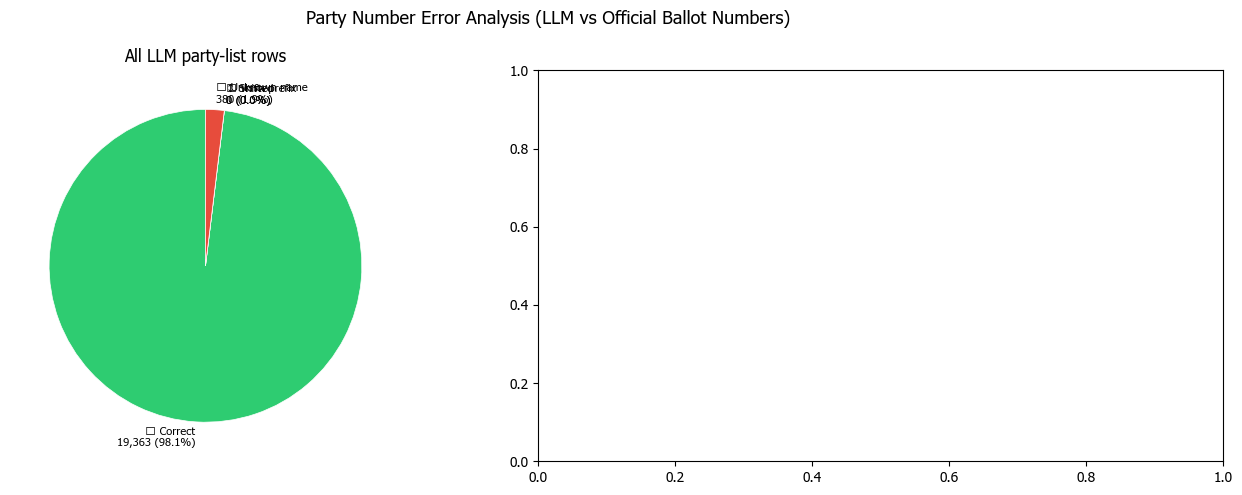

Saved → assets/killernay/party_number_errors.png


In [23]:
# ── Visualization ───────────────────────────────────────────────────────────
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle('Party Number Error Analysis (LLM vs Official Ballot Numbers)', fontsize=13)

# Left: top-level category pie
ax = axes[0]
cat_map = {
    'correct':        (correct_n, '#2ecc71', '✅ Correct'),
    'shifted':        (shifted_n, '#3498db', '↕️ Shifted'),
    'พรรค_prefix':   (prefix_n,  '#f39c12', '🏷️ พรรค prefix'),
    'unknown_party':  (unknown_n, '#e74c3c', '❓ Unknown name'),
}
sizes  = [v[0] for v in cat_map.values()]
colors = [v[1] for v in cat_map.values()]
labels = [f'{v[2]}\n{v[0]:,} ({v[0]/total*100:.1f}%)' for v in cat_map.values()]
ax.pie(sizes, labels=labels, colors=colors, startangle=90,
       textprops={'fontsize': 8}, wedgeprops={'linewidth': 0.5, 'edgecolor': 'white'})
ax.set_title('All LLM party-list rows')

# Right: shift distribution (only rows with known official name)
ax = axes[1]
shift_series = (
    df_orig[df_orig['official_number'].notna()]['error_type']
    .where(df_orig['error_type'].str.startswith('shift'))
    .dropna()
    .str.extract(r'shift_([+-]\d+)')[0]
    .astype(int)
)
if len(shift_series):
    shift_counts = shift_series.value_counts().sort_index()
    colors_bar = ['#e74c3c' if v == 1 else '#3498db' for v in shift_counts.index]
    ax.bar(shift_counts.index, shift_counts.values, color=colors_bar, edgecolor='white')
    ax.axvline(0, color='black', linestyle='--', linewidth=1, alpha=0.4)
    ax.set_xlabel('Shift (LLM number − official number)')
    ax.set_ylabel('Count')
    ax.set_title(f'Shift distribution\n(red = +1 dominates with {shift_counts.get(1,0):,} rows)')
    ax.annotate(f'+1: {shift_counts.get(1,0):,}', xy=(1, shift_counts.get(1,0)),
                xytext=(3, shift_counts.get(1,0)*0.9), fontsize=9,
                arrowprops=dict(arrowstyle='->', color='red'), color='red')

plt.tight_layout()
plt.savefig(ASSETS / 'party_number_errors.png', dpi=120, bbox_inches='tight')
plt.show()
print('Saved → assets/killernay/party_number_errors.png')


## 10. Discrepancy Distribution Plots

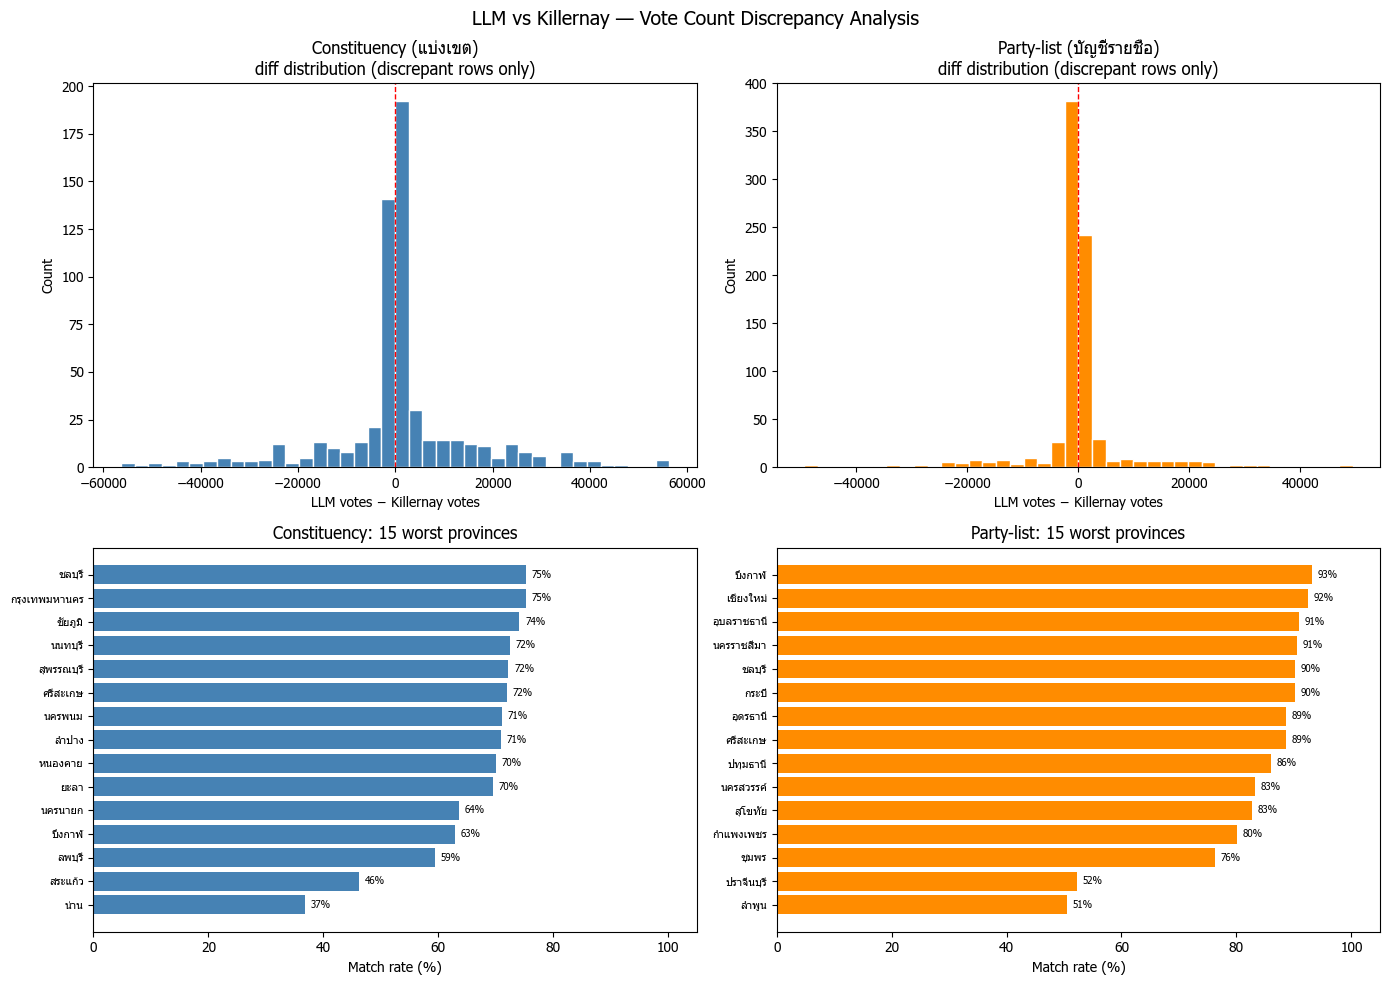

In [24]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('LLM vs Killernay — Vote Count Discrepancy Analysis', fontsize=14)

# ── Diff distributions ──
for ax, df, label, color in [
    (axes[0, 0], both_con, 'Constituency (แบ่งเขต)',     'steelblue'),
    (axes[0, 1], both_pl,  'Party-list (บัญชีรายชื่อ)', 'darkorange'),
]:
    diffs = df['diff'].dropna().astype(int)
    ax.hist(diffs[diffs != 0], bins=40, color=color, edgecolor='white')
    ax.axvline(0, color='red', linestyle='--', linewidth=1)
    ax.set_title(f'{label}\ndiff distribution (discrepant rows only)')
    ax.set_xlabel('LLM votes − Killernay votes')
    ax.set_ylabel('Count')

# ── Match rate by province (worst 15) ──
for ax, df, label, color in [
    (axes[1, 0], both_con, 'Constituency: 15 worst provinces',  'steelblue'),
    (axes[1, 1], both_pl,  'Party-list: 15 worst provinces',    'darkorange'),
]:
    worst = df.groupby('province')['match'].mean().sort_values().head(15).mul(100)
    ax.barh(range(len(worst)), worst.values, color=color)
    ax.set_yticks(range(len(worst)))
    ax.set_yticklabels(worst.index, fontsize=8)
    ax.set_xlabel('Match rate (%)')
    ax.set_title(label)
    ax.set_xlim(0, 105)
    for i, v in enumerate(worst.values):
        ax.text(v + 1, i, f'{v:.0f}%', va='center', fontsize=7)

plt.tight_layout()
plt.savefig(ASSETS / 'comparison_summary.png', dpi=120, bbox_inches='tight')
plt.show()

## 11. Correlation — LLM vs Killernay Votes

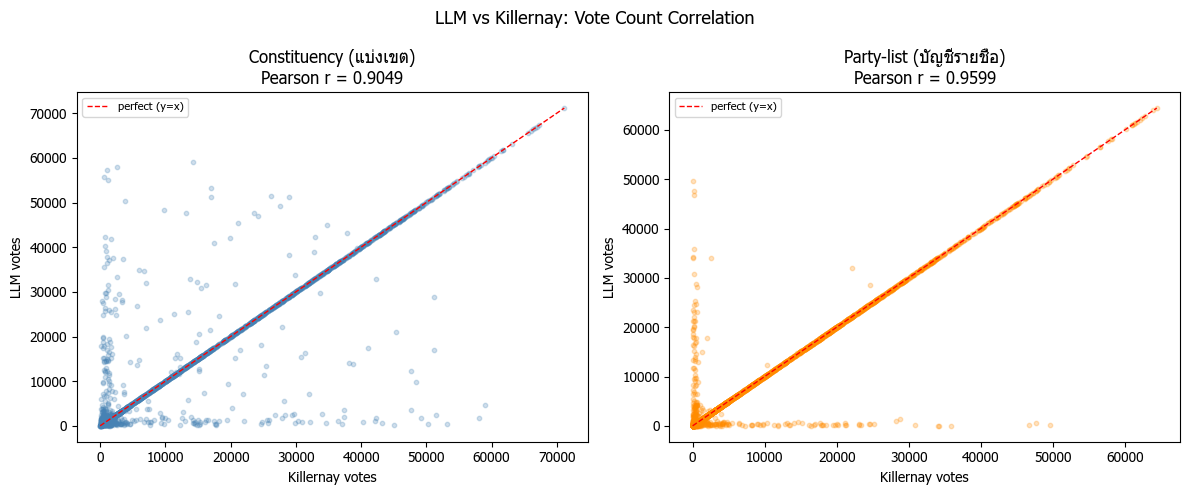

In [25]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle('LLM vs Killernay: Vote Count Correlation', fontsize=13)

for ax, df, label, color in [
    (axes[0], both_con, 'Constituency (แบ่งเขต)',     'steelblue'),
    (axes[1], both_pl,  'Party-list (บัญชีรายชื่อ)', 'darkorange'),
]:
    vl = df['votes_llm'].astype(float)
    vk = df['votes_kn'].astype(float)
    ax.scatter(vk, vl, alpha=0.25, s=10, color=color)
    max_val = max(vk.max(), vl.max())
    ax.plot([0, max_val], [0, max_val], 'r--', linewidth=1, label='perfect (y=x)')
    corr = vl.corr(vk)
    ax.set_title(f'{label}\nPearson r = {corr:.4f}')
    ax.set_xlabel('Killernay votes')
    ax.set_ylabel('LLM votes')
    ax.legend(fontsize=8)

plt.tight_layout()
plt.show()

## 12. Per-Province Error Table

In [26]:
def province_error_table(df, label):
    tbl = (
        df.groupby('province')
        .agg(
            n_rows     = ('match', 'count'),
            n_match    = ('match', 'sum'),
            n_disc     = ('match', lambda x: (~x).sum()),
            match_pct  = ('match', lambda x: round(x.mean() * 100, 1)),
            mean_diff  = ('abs_diff', lambda x: round(x.mean(), 1)),
            max_diff   = ('abs_diff', 'max'),
        )
        .sort_values('match_pct')
    )
    print(f'\n{label} — Per-Province Error Summary (worst first):')
    display(tbl)
    return tbl

tbl_con = province_error_table(both_con, 'Constituency')
tbl_pl  = province_error_table(both_pl,  'Party-list')


Constituency — Per-Province Error Summary (worst first):


,n_rows,n_match,n_disc,match_pct,mean_diff,max_diff
province,,,,,,
น่าน,19,7,12,36.8,5646.1,27935
สระแก้ว,26,12,14,46.2,2497.4,24970
ลพบุรี,37,22,15,59.5,6143.5,47448
บึงกาฬ,27,17,10,63.0,2396.6,31481
นครนายก,11,7,4,63.6,775.8,3885
ยะลา,23,16,7,69.6,3138.1,22746
หนองคาย,20,14,6,70.0,2744.6,18038
ลำปาง,31,22,9,71.0,3840.8,44124
นครพนม,38,27,11,71.1,2153.9,34209



Party-list — Per-Province Error Summary (worst first):


,n_rows,n_match,n_disc,match_pct,mean_diff,max_diff
province,,,,,,
ลำพูน,95,48,47,50.5,2100.8,46579
ปราจีนบุรี,90,47,43,52.2,1524.1,30733
ชุมพร,143,109,34,76.2,1038.6,49479
กำแพงเพชร,191,153,38,80.1,487.5,14145
สุโขทัย,191,158,33,82.7,268.2,14925
นครสวรรค์,287,239,48,83.3,619.9,22867
ปทุมธานี,380,327,53,86.1,447.3,35783
ศรีสะเกษ,429,380,49,88.6,330.3,24927
อุดรธานี,430,381,49,88.6,280.7,24226


## 13. Missing Data — Rows Only in One Dataset

In [27]:
# Constituency
only_llm_con_rows = merged_con[merged_con['votes_kn'].isna()]
only_kn_con_rows  = merged_con[merged_con['votes_llm'].isna()]

print(f'Constituency — ONLY in LLM (no killernay name match): {len(only_llm_con_rows):,}')
if len(only_llm_con_rows):
    display(only_llm_con_rows[['province','constituency','number_llm','candidate_name','party_llm','votes_llm']].head(20))

print(f'\nConstituency — ONLY in Killernay (no LLM name match): {len(only_kn_con_rows):,}')
if len(only_kn_con_rows):
    display(only_kn_con_rows[['province','constituency','number_kn','candidate_name','party_kn','votes_kn']].head(20))


Constituency — ONLY in LLM (no killernay match): 122


,province,constituency,number,candidate_name_llm,party_llm,votes_llm
223,กรุงเทพมหานคร,13,10,นายกฤษฎ์ เครือเจริญพร,พรรครวมไทยสร้างชาติ,1887
246,กรุงเทพมหานคร,14,17,นายธีระยุทธ อรุณพูลทรัพย์,เศรษฐกิจ,1199
569,กาฬสินธุ์,1,12,นายจักรินทร์ พิมรินทร์,พรรครวมไทยสร้างชาติ,700
615,กาฬสินธุ์,5,13,นายวรพรต สมบัติมล,ทางเลือกใหม่,457
626,กาฬสินธุ์,6,11,นายปรีชา นันอำไพ,ประชาธิปัตย์,425
675,ขอนแก่น,2,10,นายอิศม์เดช ฤๅชา,ไทยภักดี,742
734,ขอนแก่น,9,5,นายศักดิ์สิทธิ์ สิงห์สุนีย์,ประชากรไทย,1612
752,จังหวัดสมุทรสงคราม,1,1,นายจิระ แก้วมณี,กล้าธรรม,28382
753,จังหวัดสมุทรสงคราม,1,2,นายธนธัส ขุนนุช,เพื่อไทย,12747
754,จังหวัดสมุทรสงคราม,1,3,นายเศรษฐ์สิริ ลักขณาอุดมเลิศ,ประชาธิปัตย์,13741



Constituency — ONLY in Killernay (no LLM match): 145


,province,constituency,number,candidate_name_kn,party_kn,votes_kn
0,Sakon Nakhon,2,1,นายอภิชาติ ตีรสวัสดิชัย,เพื่อไทย,19074
1,Sakon Nakhon,2,2,นายภาสพล อุฬารกุล,ประชาชน,15466
2,Sakon Nakhon,2,3,นางสาวเพชรา อัคราชศรี,รวมไทยสร้างชาติ,584
3,Sakon Nakhon,2,4,นายชาตรี หล้าพรหม,กล้าธรรม,25737
4,Sakon Nakhon,2,5,นางสาวณภัชชา ศิลปะรายะ,ภูมิใจไทย,20809
5,Sakon Nakhon,2,6,นายนิยม เวชกามา,โอกาสใหม่,1298
6,Sakon Nakhon,2,7,นางสาวนัฐภรณ์ วงค์ขาชม,ประชาธิปัตย์,279
7,Sakon Nakhon,2,8,นายวิชิต ม่อมพะเนาว์,เศรษฐกิจ,633
8,กระบี่,1,1,นายสุวรรณ อินพรหม,เพื่อไทย,2308
9,กระบี่,1,2,นายกิตติ กิตติธรกุล,ภูมิใจไทย,50493


In [28]:
# Party-list
only_llm_pl_rows = merged_pl[merged_pl['votes_kn'].isna()]
only_kn_pl_rows  = merged_pl[merged_pl['votes_llm'].isna()]

print(f'Party-list — ONLY in LLM (no killernay match): {len(only_llm_pl_rows):,}')
if len(only_llm_pl_rows):
    display(only_llm_pl_rows[['province','constituency','party_llm','number_llm','votes_llm']].head(20))

print(f'\nParty-list — ONLY in Killernay (no LLM match): {len(only_kn_pl_rows):,}')
if len(only_kn_pl_rows):
    display(only_kn_pl_rows[['province','constituency','party_kn','number_kn','votes_kn']].head(20))

Party-list — ONLY in LLM (no killernay match): 1,739


,province,constituency,party_llm,number_llm,votes_llm
132,กระบี่,1,พลัง,51,26
146,กระบี่,1,วินัยไทย,24,111
157,กระบี่,1,เศรษฐกิจ,11,1549
162,กระบี่,1,โอกาสไทย,44,50
172,กระบี่,1,ไทยรวมพลัง,21,30
194,กระบี่,2,พลัง,51,11
208,กระบี่,2,วินัยไทย,24,158
223,กระบี่,2,โอกาสไทย,44,151
233,กระบี่,2,ไทยรวมพลัง,21,37
255,กระบี่,3,พลัง,51,34



Party-list — ONLY in Killernay (no LLM match): 4,000


,province,constituency,party_kn,number_kn,votes_kn
0,Bangkok,7,กรีน,39,74
1,Bangkok,7,กล้าธรรม,42,153
2,Bangkok,7,ก้าวอิสระ,22,9
3,Bangkok,7,ครูไทยเพื่อประชาชน,32,15
4,Bangkok,7,คลองไทย,26,17
5,Bangkok,7,ความหวังใหม่,54,10
6,Bangkok,7,ทางเลือกใหม่,10,454
7,Bangkok,7,ท้องที่ไทย,14,20
8,Bangkok,7,ประชากรไทย,31,51
9,Bangkok,7,ประชาชน,46,40808


## 14. Export Discrepancies to CSV

In [29]:
# Constituency discrepancies
out_con = ASSETS / 'discrepancies_constituency.csv'
disc_con[[
    'province', 'constituency', 'number', 'candidate_name_llm', 'party_llm',
    'votes_llm', 'votes_kn', 'diff', 'abs_diff',
]].rename(columns={'candidate_name_llm': 'candidate_name', 'party_llm': 'party'}
).to_csv(out_con, index=False)
print(f'Saved {len(disc_con):,} constituency discrepancy rows → {out_con}')

# Party-list discrepancies
out_pl = ASSETS / 'discrepancies_party_list.csv'
disc_pl[[
    'province', 'constituency', 'party_llm', 'number_llm', 'number_kn',
    'votes_llm', 'votes_kn', 'diff', 'abs_diff',
]].rename(columns={'party_llm': 'party', 'number_llm': 'llm_number', 'number_kn': 'kn_number'}
).to_csv(out_pl, index=False)
print(f'Saved {len(disc_pl):,} party-list discrepancy rows   → {out_pl}')

Saved 592 constituency discrepancy rows → assets/killernay/discrepancies_constituency.csv
Saved 792 party-list discrepancy rows   → assets/killernay/discrepancies_party_list.csv


## 15. Drill-Down: Inspect a Specific Province/Constituency

In [30]:
# ← Change these to inspect any (province, constituency) pair
PROVINCE     = 'ลำพูน'
CONSTITUENCY = 1

print(f'=== Constituency: {PROVINCE} เขต {CONSTITUENCY} ===')
sub_con = (
    both_con[(both_con['province'] == PROVINCE) & (both_con['constituency'] == CONSTITUENCY)]
    .sort_values('number')
)
display(sub_con[['number', 'candidate_name_llm', 'party_llm',
                 'votes_llm', 'votes_kn', 'diff', 'match']].reset_index(drop=True))

print(f'\n=== Party-list: {PROVINCE} เขต {CONSTITUENCY} ===')
sub_pl = (
    both_pl[(both_pl['province'] == PROVINCE) & (both_pl['constituency'] == CONSTITUENCY)]
    .sort_values('number_kn')
)
display(sub_pl[['party_llm', 'number_llm', 'number_kn',
                'votes_llm', 'votes_kn', 'diff', 'match']].reset_index(drop=True))

=== Constituency: ลำพูน เขต 1 ===


,number,candidate_name_llm,party_llm,votes_llm,votes_kn,diff,match
0,1,นายวิทวิสิทธิ์ ปันสวนปลูก,ประชาชน,66093,66093,0,True
1,2,นายชัยณรงค์ ภู่พิสิฐ,เพื่อไทย,29768,864,28904,False
2,2,นายณัฏฐชัย วงค์ชัยรุ่งเรือง,ไทยก้าวใหม่,864,864,0,True
3,3,นายยุทธพงศ์ ไชยศร,ภูมิใจไทย,8919,8919,0,True
4,4,นางสาวพัชราภรณ์ เอื้องฟ้า,ประชาธิปัตย์,7369,7369,0,True
5,5,นายประกอบ ยอดยา,กล้าธรรม,4395,2666,1729,False
6,6,นายสุริยา บุญนาคค้า,เสรีรวมไทย,3352,4395,-1043,False
7,7,นายชวิน คำบุญเรือง,รวมไทยสร้างชาติ,1566,1566,0,True
8,8,นายสุวสันต์ จันทร์ตาธรรม,เศรษฐกิจ,2666,29768,-27102,False
9,10,นายสมบัติ ใจแจ่ม,วิชชั่นใหม่,334,334,0,True



=== Party-list: ลำพูน เขต 1 ===


,party_llm,number_llm,number_kn,votes_llm,votes_kn,diff,match
0,ไทยทรัพย์ทวี,1,1,1411,1411,0,True
1,เพื่อชาติไทย,2,2,1343,1343,0,True
2,ใหม่,3,3,499,499,0,True
3,มิติใหม่,4,4,471,471,0,True
4,รวมใจไทย,5,5,519,519,0,True
5,รวมไทยสร้างชาติ,6,6,1949,1949,0,True
6,พลวัต,7,7,208,208,0,True
7,ประชาธิปไตยใหม่,8,8,1772,1772,0,True
8,เพื่อไทย,9,9,30632,30632,0,True
9,ทางเลือกใหม่,10,10,482,482,0,True


## 16. Executive Summary

In [ ]:
tc, mc = len(both_con), both_con['match'].sum()
tp, mp = len(both_pl),  both_pl['match'].sum()

print('╔══════════════════════════════════════════════════════════════╗')
print('║          EXECUTIVE SUMMARY: LLM vs Killernay                ║')
print('╠══════════════════════════════════════════════════════════════╣')
print(f'║  Model  : Gemini 2.5 Pro (thinking=LOW, temp=0.0)           ║')
print(f'║  Source : llm_constituency.csv + llm_party_list.csv         ║')
print('╠══════════════════════════════════════════════════════════════╣')
print(f'║  CONSTITUENCY (แบ่งเขต)                                      ║')
print(f'║    Matched rows  : {tc:>6,}                                ║')
print(f'║    Exact matches : {mc:>6,}  ({mc/tc*100:5.1f}%)                   ║')
print(f'║    Discrepancies : {tc-mc:>6,}  ({(tc-mc)/tc*100:5.1f}%)                   ║')
print(f'║    Mean |diff|   : {both_con["abs_diff"].mean():>9.1f}                       ║')
print('╠══════════════════════════════════════════════════════════════╣')
print(f'║  PARTY-LIST (บัญชีรายชื่อ)                                   ║')
print(f'║    Matched rows  : {tp:>6,}                                ║')
print(f'║    Exact matches : {mp:>6,}  ({mp/tp*100:5.1f}%)                   ║')
print(f'║    Discrepancies : {tp-mp:>6,}  ({(tp-mp)/tp*100:5.1f}%)                   ║')
print(f'║    Mean |diff|   : {both_pl["abs_diff"].mean():>9.1f}                       ║')
print(f'║    Number mismatches: {len(number_mismatches):>4,} rows (wrong #, correct votes)  ║')
print('╚══════════════════════════════════════════════════════════════╝')